In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os.path
import os
#plt.rcParams['figure.figsize'] = [15, 3.5]

In [42]:
def gen_model(x, a, b, c, d, e):
    return a*x[:, 0] + b*x[:, 1] + c*x[:, 0]**2 + d*x[:, 1]**2 + e*x[:, 0]*x[:, 1]

def draw_heatmaps(df, labels, suptitle, filename_base=None, show=False):
    x = df['x'].to_numpy()
    n_pts = int(np.sqrt(x.shape[0]))
    x_uniq = x[:n_pts]
    fig, axs = plt.subplots(1, len(labels), figsize=(25.0/4.0*len(labels), 4.5))
    fig.subplots_adjust(top=0.85)
    for label, ax in zip(labels, axs):
        mse = df[label].mean()
        z = df[label].to_numpy()
        z = z.reshape(n_pts, n_pts)
        c_ = ax.contourf(x_uniq, x_uniq, z, levels=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(label + f' {mse:.8f}')
        plt.colorbar(c_, ax=ax)
    fig.suptitle(suptitle)
    if filename_base:
        filename_output_png = f'processed/{filename_base}.png'
        plt.savefig(filename_output_png, bbox_inches='tight')
        if not show:
            plt.close()

def get_suptitle(n, a, b, c, d, e, eps, X, degree):
    return f'n={n}; {a}*X1 + {b}*X2 + {c}*X1^2 + {d}*X2^2 + {e}*X1X2 + N(0, {eps}); degree={degree}; X1, X2 ~ {X}'

def get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X, degree):
    return f'BMR2d_n={n}_a={a:.3f}_b={b:.3f}_c={c:.3f}_d{d:.3f}_e{e:.3f}_eps={eps:.4f}_{substitution_policy}_X{X}_degree{degree}'

def get_bmr_params(n, a, b, c, d, e, eps, substitution_policy, X, degree):
    filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X, degree)
    filename_input_pickle = f'csv/{filename_base}.pickle'
    dat = pickle.load(open(filename_input_pickle, 'rb'))
    return dat[0]['epsilon'], dat[0]['min_n_pts']

def process_csv(n, a, b, c, d, e, eps, substitution_policy, X, degree):
    filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X, degree)
    filename_input_csv = f'csv/{filename_base}.csv'
    filename_input_pickle = f'csv/{filename_base}.pickle'
    filenaout_output_csv = f'processed/{filename_base}.csv'
    if not os.path.exists(filename_input_csv):
        raise ValueError(f'{filename_input_csv} not found. Skipping ')
    suptitle = get_suptitle(n, a, b, c, d, e, eps, X, degree)
    df = pd.read_csv(filename_input_csv)
    df['value'] = gen_model(df[['x', 'y']].to_numpy(), a, b, c, d, e)
    df['slope1'] = a + 2*c*df[['x']].to_numpy() + e*df[['y']].to_numpy()
    df['slope2'] = b + 2*d*df[['y']].to_numpy() + e*df[['x']].to_numpy()
    df['slope1_in_CI'] = [int(x) for x in np.logical_and(df['slope1'] <= df['BMR_beta1_up'], df['slope1'] >= df['BMR_beta1_low'])]
    df['slope2_in_CI'] = [int(x) for x in np.logical_and(df['slope2'] <= df['BMR_beta2_up'], df['slope2'] >= df['BMR_beta2_low'])]
    df.to_csv(filenaout_output_csv, index=False)
    return df

def get_cut_df(df, xmin, xmax):
    return df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= xmin) & (df['y'] <= xmax)]

def get_mean_mse(df):
    return df[['LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE']].mean()

In [43]:
n=1000
a=1
b=2
c=0
d=0
e=0.2
eps=0.1
degree=1
X='U'
substitution_policy='nearest'

mses = []
filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X, degree)
                                  
df = process_csv(n, a, b, c, d, e, eps, substitution_policy, X, degree)
df_cut = get_cut_df(df, -3, 3)
mses.append([n, a, b, c, d, e, eps, degree, X, *get_mean_mse(df)])
suptitle=get_suptitle(n, a, b, c, d, e, eps, X, degree)

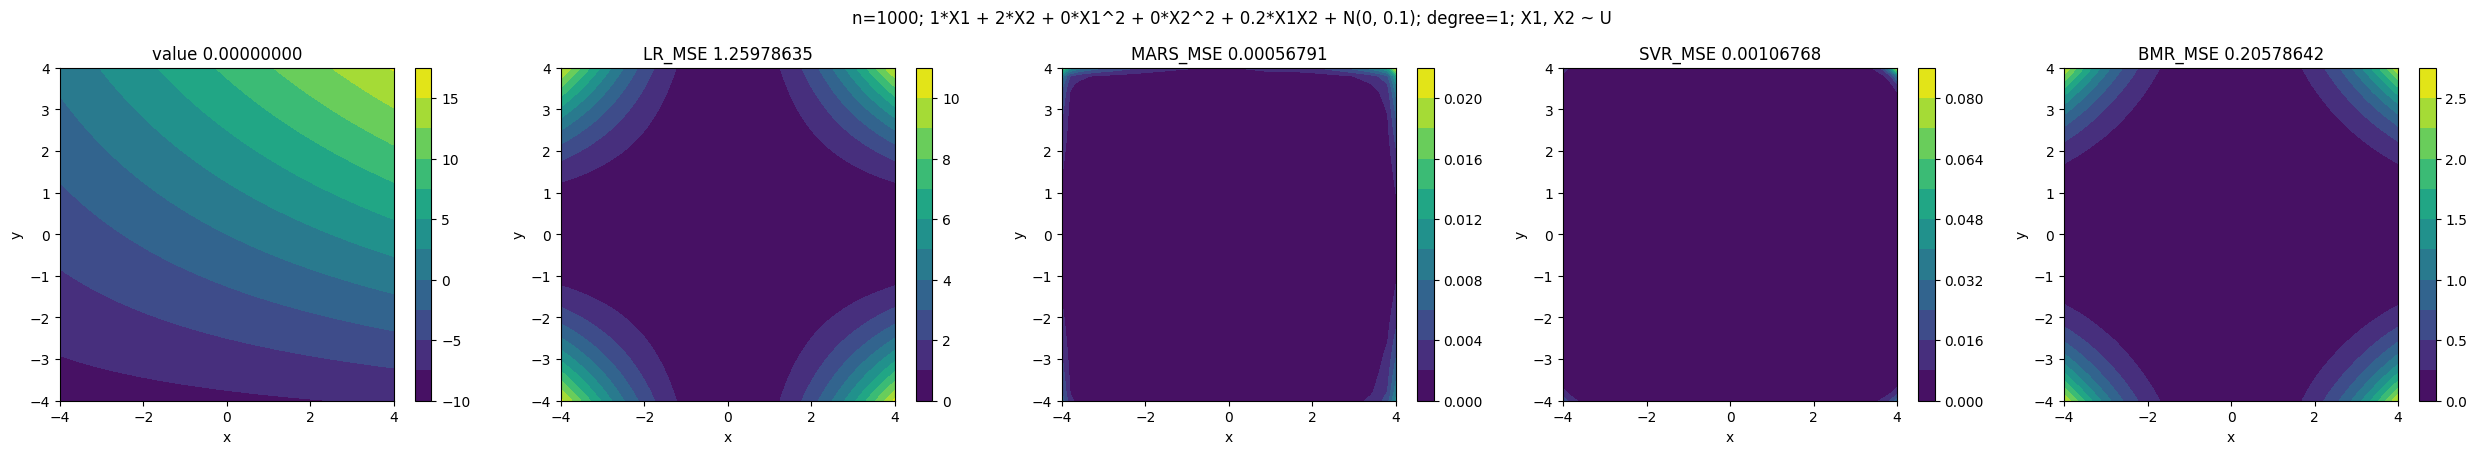

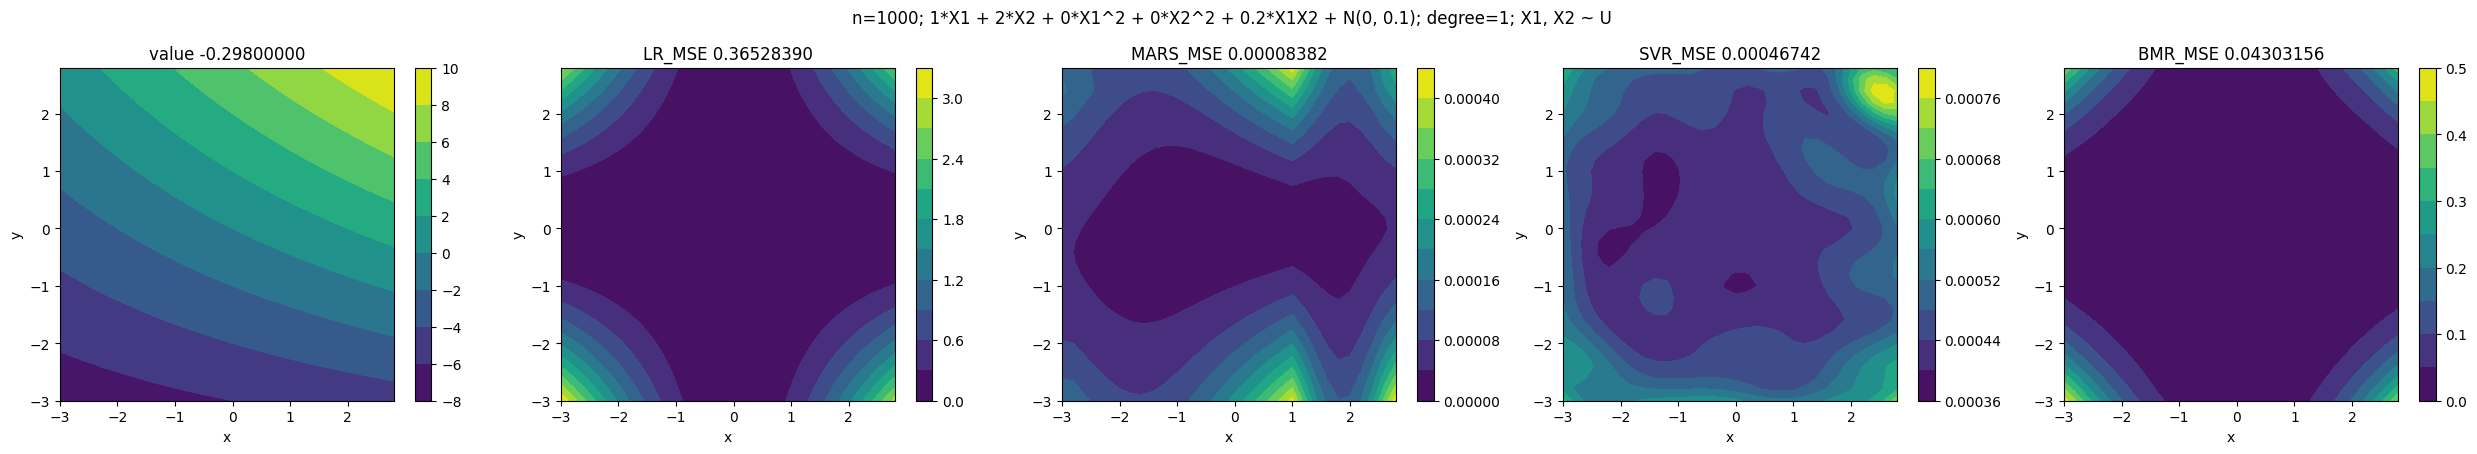

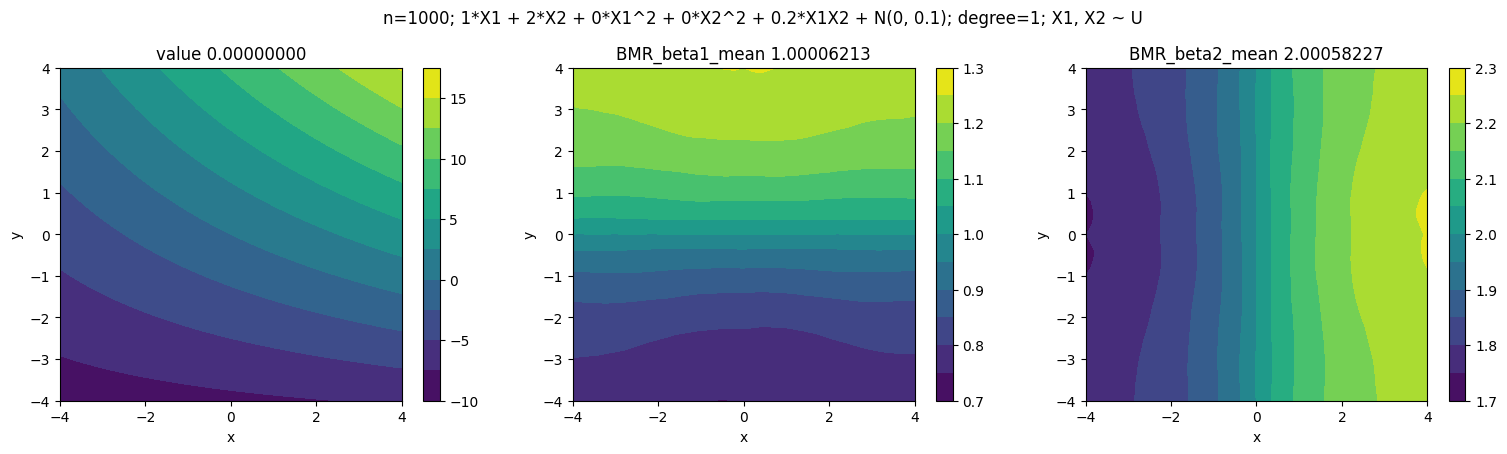

In [44]:
draw_heatmaps(df, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_{filename_base}', show=True)
draw_heatmaps(df_cut, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_cut_{filename_base}', show=True)
draw_heatmaps(df, labels=['value', 'BMR_beta1_mean', 'BMR_beta2_mean'], suptitle=suptitle, filename_base=f'CI_{filename_base}', show=True)

In [45]:
def run_plot(n, a, b, c, d, e, eps, substitution_policy, X, degree):
    mses = []
    mses_cut = []
    filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X, degree)
    try:
        df = process_csv(n, a, b, c, d, e, eps, substitution_policy, X, degree)
        df_cut = get_cut_df(df, -3, 3)
        bmr_params = get_bmr_params(n, a, b, c, d, e, eps, substitution_policy, X, degree)
        mse = [n, a, b, c, d, e, eps, degree, X, *get_mean_mse(df), *bmr_params]
        mse_cut = [n, a, b, c, d, e, eps, degree, X, *get_mean_mse(df_cut), *bmr_params]
        suptitle=get_suptitle(n, a, b, c, d, e, eps, X, degree)
        draw_heatmaps(df, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_{filename_base}')
        draw_heatmaps(df_cut, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_cut_{filename_base}')
        draw_heatmaps(df, labels=['value', 'BMR_beta1_mean', 'BMR_beta2_mean'], suptitle=suptitle, filename_base=f'CI_{filename_base}')
        return mse, mse_cut
    except:
        print(f'Error in {filename_base}')
        return None, None

In [47]:
ns = [500, 1000, 2000, 3000]
Xs = ['U', 'N']
epss = [0.01, 0.1, 0.3]
degree=1
mses = []
mses_cut = []
substitution_policy='nearest'
for n in ns:
    for X in Xs:
        for eps in epss:
            # m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:
            #     mses.append(m1); mses_cut.append(m2)
            # m1, m2 = run_plot(n, a=1, b=2, c=-1, d=3, e=0, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:b
            #     mses.append(m1); mses_cut.append(m2)
            # m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0.2, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:
            #     mses.append(m1); mses_cut.append(m2)
            # m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0.5, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:
            #     mses.append(m1); mses_cut.append(m2)
            m1, m2 = run_plot(n, a=1, b=2, c=-1, d=3, e=0.5, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            if m1 and m2:
                mses.append(m1); mses_cut.append(m2)

Error in BMR2d_n=3000_a=1.000_b=2.000_c=-1.000_d3.000_e0.500_eps=0.3000_nearest_XU_degree1
Error in BMR2d_n=3000_a=1.000_b=2.000_c=-1.000_d3.000_e0.500_eps=0.0100_nearest_XN_degree1
Error in BMR2d_n=3000_a=1.000_b=2.000_c=-1.000_d3.000_e0.500_eps=0.1000_nearest_XN_degree1
Error in BMR2d_n=3000_a=1.000_b=2.000_c=-1.000_d3.000_e0.500_eps=0.3000_nearest_XN_degree1


In [54]:
# n, a, b, c, d, e, eps, degree, X, *get_mean_mse(df)
#df_mses = pd.DataFrame(mses, columns=['n', 'a', 'b', 'c', 'd', 'e', 'eps', 'degree', 'X', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE', 'BMR_eps', 'BMR_npts'])
df_mses_cut = pd.DataFrame(mses_cut, columns=['n', 'a', 'b', 'c', 'd', 'e', 'eps', 'degree', 'X', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE', 'BMR_eps', 'BMR_npts'])
# df_mses_cut = pd.DataFrame(mses_cut, columns=['n', 'a', 'b', 'c', 'd', 'e', 'eps', 'degree', 'X', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'])
# df_mses.to_csv('MSE.csv', index=False)
# df_mses_cut.to_csv('MSE_cut.csv', index=False)

In [55]:
df_mses_cut

,n,a,b,c,d,e,eps,degree,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts
0,500,1,2,-1,3,0.5,0.01,1,U,97.740794,1.433211,0.003215,24.996533,4.0,98
1,500,1,2,-1,3,0.5,0.10,1,U,97.358854,1.441383,0.001544,25.119171,4.0,98
2,500,1,2,-1,3,0.5,0.30,1,U,97.702966,1.423247,0.008335,25.212262,4.0,98
3,500,1,2,-1,3,0.5,0.01,1,N,92.193041,2.681618,1.505281,75.203192,4.0,6
4,500,1,2,-1,3,0.5,0.10,1,N,92.263341,2.183113,1.950637,92.471893,4.0,220
5,500,1,2,-1,3,0.5,0.30,1,N,92.204346,1.910463,2.586999,92.081975,4.0,98
6,1000,1,2,-1,3,0.5,0.01,1,U,97.107003,1.484355,0.000023,25.190437,4.0,196
7,1000,1,2,-1,3,0.5,0.10,1,U,97.402530,1.486904,0.000645,24.795791,4.0,196
8,1000,1,2,-1,3,0.5,0.30,1,U,97.171890,1.461718,0.043621,24.958993,4.0,196
9,1000,1,2,-1,3,0.5,0.01,1,N,91.693775,1.815965,0.290402,91.542297,4.0,196


In [53]:
df_mses

,n,a,b,c,d,e,eps,degree,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts
0,500,1,2,-1,3,0.5,0.01,1,U,260.338478,2.067130,0.008439,92.441399,4.0,98
1,500,1,2,-1,3,0.5,0.10,1,U,260.344083,2.089912,0.006846,92.549994,4.0,98
2,500,1,2,-1,3,0.5,0.30,1,U,260.328940,2.061602,0.022366,92.533054,4.0,98
3,500,1,2,-1,3,0.5,0.01,1,N,344.335671,32.059463,88.114564,289.083587,4.0,6
4,500,1,2,-1,3,0.5,0.10,1,N,344.583943,26.423747,94.696291,344.720080,4.0,220
5,500,1,2,-1,3,0.5,0.30,1,N,344.404607,17.877814,102.579062,342.943210,4.0,98
6,1000,1,2,-1,3,0.5,0.01,1,U,259.421887,2.116752,0.000307,92.364052,4.0,196
7,1000,1,2,-1,3,0.5,0.10,1,U,259.389343,2.129682,0.002114,91.701706,4.0,196
8,1000,1,2,-1,3,0.5,0.30,1,U,259.443115,2.100113,0.396096,92.136657,4.0,196
9,1000,1,2,-1,3,0.5,0.01,1,N,343.685338,19.003977,45.063327,342.347124,4.0,196


In [37]:
df_mses

,n,a,b,c,d,e,eps,degree,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts
0,500,1,2,0,0,0,0.01,1,U,6.323787e-07,1.274022e-06,0.000132,0.000021,0.50,6
1,500,1,2,0,0,0,0.10,1,U,5.993634e-05,8.781962e-01,0.001961,0.002121,0.50,6
2,500,1,2,0,0,0,0.30,1,U,5.413743e-04,9.067586e-01,0.013556,0.019209,0.50,6
3,500,1,2,0,0,0,0.01,1,N,2.528236e-06,7.520631e-01,6.958569,0.000343,0.25,6
4,500,1,2,0,0,0,0.10,1,N,2.469645e-04,8.464444e-01,8.043977,0.034328,0.25,6
5,500,1,2,0,0,0,0.30,1,N,2.281968e-03,8.166927e-01,9.144158,0.307952,0.25,6
6,1000,1,2,0,0,0,0.01,1,U,2.973111e-07,7.866456e-07,0.000019,0.000008,0.50,12
7,1000,1,2,0,0,0,0.10,1,U,2.956480e-05,7.720668e-05,0.001018,0.000801,0.50,12
8,1000,1,2,0,0,0,0.30,1,U,2.825626e-04,1.004385e-03,0.005801,0.007211,0.50,12
9,1000,1,2,0,0,0,0.01,1,N,1.253029e-06,9.586629e-01,4.397802,0.000073,0.25,12
